In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

%matplotlib inline


In [3]:
os.getcwd()

'/Users/Daniel1020/Documents/Business Analytics/Python/Project'

In [4]:
os.chdir('/Users/Daniel1020/Downloads/Pricing_Test')

In [6]:
test_results=pd.read_csv('test_results.csv')
user_table=pd.read_csv('user_table.csv')

In [9]:
test_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 8 columns):
user_id             316800 non-null int64
timestamp           316800 non-null object
source              316800 non-null object
device              316800 non-null object
operative_system    316800 non-null object
test                316800 non-null int64
price               316800 non-null int64
converted           316800 non-null int64
dtypes: int64(4), object(4)
memory usage: 19.3+ MB


In [10]:
test_results.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [11]:
user_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275616 entries, 0 to 275615
Data columns (total 5 columns):
user_id    275616 non-null int64
city       275616 non-null object
country    275616 non-null object
lat        275616 non-null float64
long       275616 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 10.5+ MB


# Data Processing and Cleaning

In [13]:
print('user_table: \t', user_table['user_id'].unique().shape)
print('test_results: \t', test_results['user_id'].unique().shape)

user_table: 	 (275616,)
test_results: 	 (316800,)


In [15]:
##  merge two tables
data=pd.merge(left=test_results, right= user_table, how='left',on= 'user_id')
data.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


In [20]:
data[['price','test','user_id']].groupby(['test','price']).count()

user_id
test price         
0    39      202517
     59         210
1    39         155
     59      113918

In [21]:
##Findings: it seems like there are a small portion of samples with wrong information:
##          such as 210 counts on users with $ 59, and 155 counts of test users of $39

In [22]:
## remover these problematic data
data= data [((data['test']==0)&(data['price']==39)) | ((data['test']==1) & (data['price']==59))]

In [25]:
## Create KPI index to identify the test performance
data['revenue']= data['price']*data['converted']

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [28]:
data.isnull().sum()

user_id                 0
timestamp               0
source                  0
device                  0
operative_system        0
test                    0
price                   0
converted               0
city                41141
country             41141
lat                 41141
long                41141
revenue                 0
dtype: int64

# Visualization
check whether or not the test is randomized 

## Source 

In [33]:
## source sample randomness check
tmp = data.groupby('test')['source'].apply(lambda x: x.value_counts(normalize=True)).unstack()
tmp

,ads-bing,ads-google,ads-yahoo,ads_facebook,ads_other,direct_traffic,friend_referral,seo-bing,seo-google,seo-other,seo-yahoo,seo_facebook
test,,,,,,,,,,,,
0,0.072014,0.186873,0.023761,0.168253,0.095083,0.191154,0.064790,0.006562,0.074502,0.029030,0.021509,0.066468
1,0.072394,0.188706,0.024219,0.169253,0.092786,0.189259,0.066337,0.007154,0.070753,0.029539,0.021814,0.067786


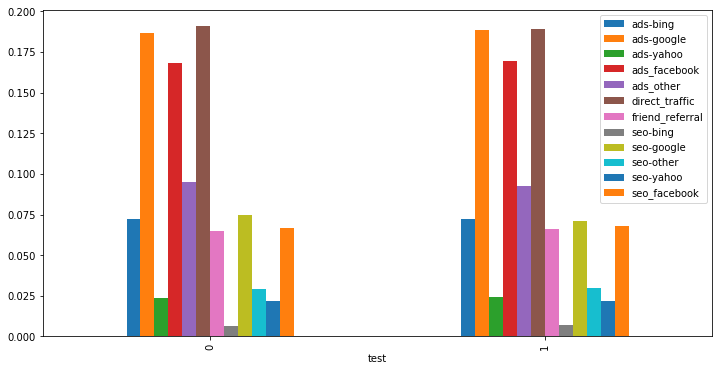

In [31]:
fig,ax=plt.subplots(figsize=(12,6))
tmp.plot(kind='bar',ax=ax)
plt.show()

In [35]:
## ransomness check on device
tmp_device=data.groupby('test')['device'].apply(lambda x: x.value_counts(normalize=True)).unstack()
tmp_device

,mobile,web
test,,
0,0.594365,0.405635
1,0.578469,0.421531


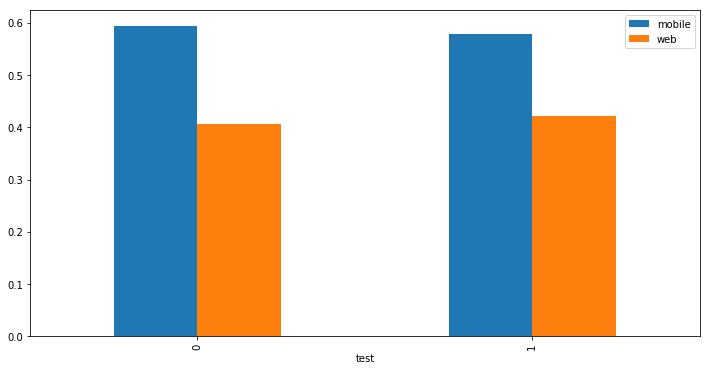

In [37]:
fig,ax=plt.subplots(figsize=(12,6))
tmp_device.plot(kind='bar',ax=ax)
plt.show()

In [41]:
## check randomness for operative_system
tmp_system=data.groupby('test')['operative_system'].apply(lambda x: x.value_counts(normalize=True)).unstack()
tmp_system

,windows,iOS,android,mac,other,linux
test,,,,,,
0,0.313638,0.305125,0.237891,0.080709,0.051754,0.010883
1,0.327718,0.294598,0.234318,0.076459,0.050001,0.016907


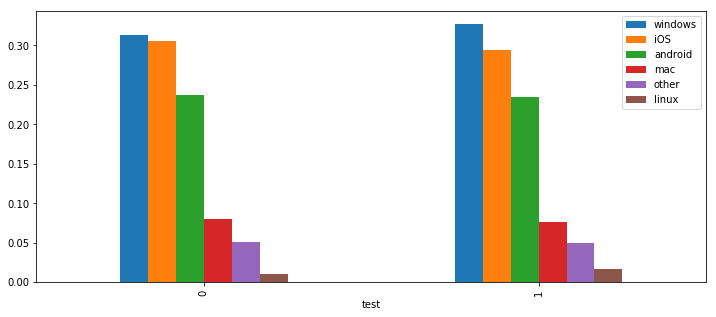

In [42]:
fig,ax=plt.subplots(figsize=(12,5))
tmp_system.plot(kind='bar',ax=ax)
plt.show()

In [50]:
tmp_system_revenue=data.groupby(['test','operative_system'])['revenue'].apply(lambda x : x.sum())
tmp_system_revenue.head()

test  operative_system
0     android             30693
      iOS                 56862
      linux                1326
      mac                 16224
      other                5733
Name: revenue, dtype: int64

In [53]:
revenue_system_percent= tmp_system_revenue.groupby(level=0).apply(lambda x: 100* x/ float (x.sum())).unstack()

In [54]:
revenue_system_percent

operative_system,android,iOS,linux,mac,other,windows
test,,,,,,
0,19.528536,36.178660,0.843672,10.322581,3.647643,29.478908
1,18.623025,37.866817,0.000000,10.440181,3.555305,29.514673


# A/B test for Conversion Rate

In [56]:
data[['test','converted']].groupby(['test']).mean()

,converted
test,
0,0.019900
1,0.015555


In [57]:
data[['test','revenue']].groupby(['test']).mean()

,revenue
test,
0,0.776083
1,0.917748


In [58]:
## Findings: For those with lower price have a higher conversion rate, but with less revenue
##          For those with higher price have a lower conversion rate , having more revenue though.

In [62]:
contr_revenue= data[data['test']==0]['revenue'].values
exper_revenue= data[data['test']==1]['revenue'].values

In [63]:
ttest_ind(contr_revenue,exper_revenue,axis=0,equal_var=False)

Ttest_indResult(statistic=-5.715224666463108, pvalue=1.0972577312420781e-08)

In [64]:
## Conclusion: From the results of A/B test, we can conclude that the difference between the revenue brought by lower price and 
## higher price is significant .

# Question 2

In [67]:
## conversion rate by sources
data.groupby('source')['converted'].mean().reset_index()

,source,converted
0,ads-bing,0.012001
1,ads-google,0.021502
2,ads-yahoo,0.014793
3,ads_facebook,0.021198
4,ads_other,0.014350
5,direct_traffic,0.012294
6,friend_referral,0.038688
7,seo-bing,0.023787
8,seo-google,0.016978
9,seo-other,0.015686


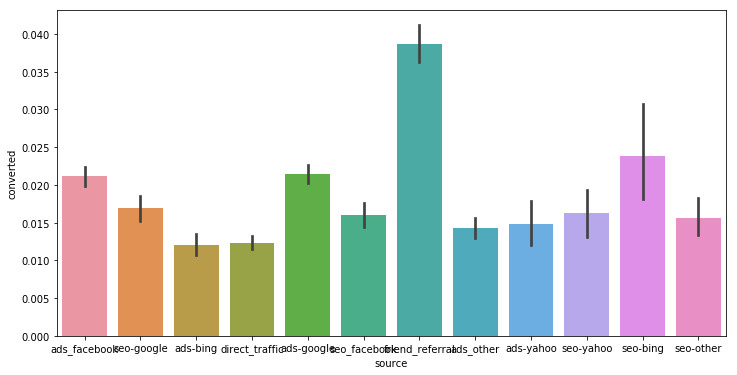

In [70]:
fig,ax=plt.subplots(figsize=(12,6))
sns.barplot(x='source',y='converted',data=data,ax=ax)
plt.show()

In [72]:
## conversion rate by device
data.groupby(['device'])['converted'].mean().reset_index()

,device,converted
0,mobile,0.018554
1,web,0.018023


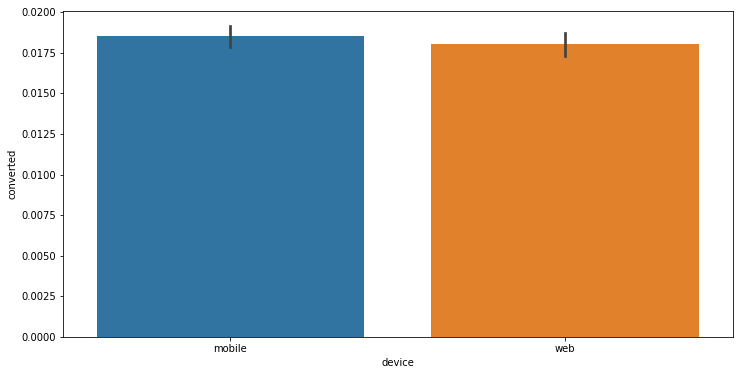

In [73]:
fig,ax=plt.subplots(figsize=(12,6))
sns.barplot(x='device',y='converted',data=data,ax=ax)
plt.show()

In [74]:
## conversion rate by operative_syste
data.groupby(['operative_system'])['converted'].mean().reset_index()

,operative_system,converted
0,android,0.014919
1,iOS,0.022328
2,linux,0.008232
3,mac,0.023987
4,other,0.012981
5,windows,0.016966


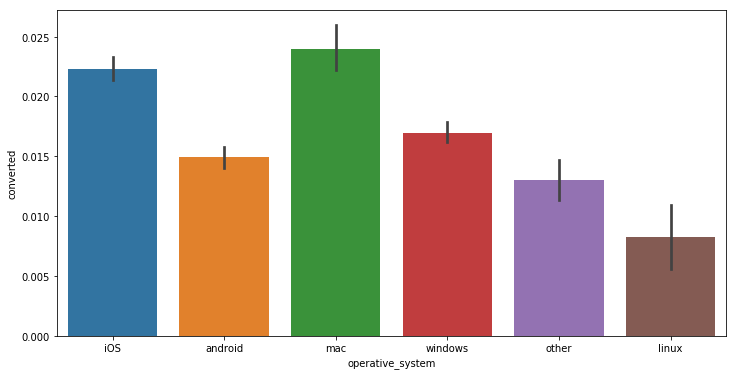

In [75]:
fig,ax=plt.subplots(figsize=(12,6))
sns.barplot(x='operative_system',y='converted',data=data,ax=ax)
plt.show()  

In [ ]:
## Findings: From the above visualization, it's clear to see that the conversion rate on source of 'friend_referal',
## system of mac ,ios is higher than other ways.
## While the conversion rate using Linux system is much lower than other, there's need to check the comparability.